In [1]:
import pandas as pd

# Load data (already done before, but safe to re-run)
df = pd.read_csv("../Data_Assets/Most-Recent-Cohorts-Institution.csv", dtype=str)

# 1️⃣ Basic structure
print("Shape (rows, columns):", df.shape)
print("\nColumn Names Sample:\n", df.columns[:20].tolist())  # show first 20 column names

# 2️⃣ Inspect data types (first 10 columns) now the rows are individual universities 
df.info(verbose=True, show_counts=True)


Shape (rows, columns): (6429, 3306)

Column Names Sample:
 ['UNITID', 'OPEID', 'OPEID6', 'INSTNM', 'CITY', 'STABBR', 'ZIP', 'ACCREDAGENCY', 'INSTURL', 'NPCURL', 'SCH_DEG', 'HCM2', 'MAIN', 'NUMBRANCH', 'PREDDEG', 'HIGHDEG', 'CONTROL', 'ST_FIPS', 'REGION', 'LOCALE']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6429 entries, 0 to 6428
Data columns (total 3306 columns):
 #     Column                            Non-Null Count  Dtype 
---    ------                            --------------  ----- 
 0     UNITID                            6429 non-null   object
 1     OPEID                             6405 non-null   object
 2     OPEID6                            6405 non-null   object
 3     INSTNM                            6429 non-null   object
 4     CITY                              6429 non-null   object
 5     STABBR                            6429 non-null   object
 6     ZIP                               6429 non-null   object
 7     ACCREDAGENCY                      6225 non-

In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv("../Data_Assets/Most-Recent-Cohorts-Institution.csv", dtype=str)

# Load the correct data dictionary sheet
dictionary = pd.read_excel(
    "../Data_Assets/collegescorecarddatadictionary.xlsx",
    sheet_name="Institution_Data_Dictionary"
)

# Preview structure
print(dictionary.columns)
dictionary.head(3251)

Index(['NAME OF DATA ELEMENT', 'dev-category', 'developer-friendly name',
       'API data type', 'INDEX', 'VARIABLE NAME', 'VALUE', 'LABEL', 'SOURCE',
       'SHOWN/USE ON SITE', 'NOTES'],
      dtype='object')


,NAME OF DATA ELEMENT,dev-category,developer-friendly name,API data type,INDEX,VARIABLE NAME,VALUE,LABEL,SOURCE,SHOWN/USE ON SITE,NOTES
0,Unit ID for institution,root,id,integer,NaN,UNITID,NaN,NaN,IPEDS,Yes,NaN
1,8-digit OPE ID for institution,root,ope8_id,string,varchar(10),OPEID,NaN,NaN,IPEDS,Yes,NaN
2,6-digit OPE ID for institution,root,ope6_id,string,varchar(10),OPEID6,NaN,NaN,IPEDS,Yes,NaN
3,Institution name,school,name,autocomplete,fulltext,INSTNM,NaN,NaN,IPEDS,Yes,NaN
4,City,school,city,autocomplete,varchar(200),CITY,NaN,NaN,IPEDS,Yes,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3246,Median earnings of students working and not en...,earnings,10_yrs_after_entry.median_earnings.highest_ter...,integer,NaN,MD_EARN_WNE_INC3_P10,NaN,NaN,Treasury,NaN,NaN
3247,Median earnings of independent students workin...,earnings,10_yrs_after_entry.median_earnings.independent...,integer,NaN,MD_EARN_WNE_INDEP1_P10,NaN,NaN,Treasury,NaN,NaN
3248,Median earnings of dependent students working ...,earnings,10_yrs_after_entry.median_earnings.dependent_s...,integer,NaN,MD_EARN_WNE_INDEP0_P10,NaN,NaN,Treasury,NaN,NaN
3249,Median earnings of non-male students working a...,earnings,10_yrs_after_entry.median_earnings.non_male_st...,integer,NaN,MD_EARN_WNE_MALE0_P10,NaN,NaN,Treasury,NaN,NaN


In [3]:
# Keep only relevant columns for clarity
dictionary_clean = dictionary[['VARIABLE NAME', 'NAME OF DATA ELEMENT', 'API data type']].dropna(subset=['VARIABLE NAME'])

# Rename for clarity
dictionary_clean.columns = ['VARIABLE_NAME', 'DESCRIPTION', 'EXPECTED_TYPE']

# Preview
dictionary_clean.head(3251)


,VARIABLE_NAME,DESCRIPTION,EXPECTED_TYPE
0,UNITID,Unit ID for institution,integer
1,OPEID,8-digit OPE ID for institution,string
2,OPEID6,6-digit OPE ID for institution,string
3,INSTNM,Institution name,autocomplete
4,CITY,City,autocomplete
...,...,...,...
3246,MD_EARN_WNE_INC3_P10,Median earnings of students working and not en...,integer
3247,MD_EARN_WNE_INDEP1_P10,Median earnings of independent students workin...,integer
3248,MD_EARN_WNE_INDEP0_P10,Median earnings of dependent students working ...,integer
3249,MD_EARN_WNE_MALE0_P10,Median earnings of non-male students working a...,integer


In [4]:
dictionary_clean = dictionary[['VARIABLE NAME', 'API data type']].dropna(subset=['VARIABLE NAME'])
dictionary_clean.columns = ['VARIABLE_NAME', 'EXPECTED_TYPE']

# Extract dataframe schema
dtype_summary = df.dtypes.reset_index()
dtype_summary.columns = ['VARIABLE_NAME', 'DATA_TYPE']

# Merge with dictionary
schema_merged = dtype_summary.merge(dictionary_clean, on='VARIABLE_NAME', how='left')
schema_merged.head(10)


,VARIABLE_NAME,DATA_TYPE,EXPECTED_TYPE
0,UNITID,object,integer
1,OPEID,object,string
2,OPEID6,object,string
3,INSTNM,object,autocomplete
4,CITY,object,autocomplete
5,STABBR,object,string
6,ZIP,object,string
7,ACCREDAGENCY,object,string
8,INSTURL,object,string
9,NPCURL,object,string


In [5]:
# Build conversion map
type_map = {
    'integer': 'Int64',      # pandas nullable integer
    'float': 'float64',
    'string': 'string',
    'autocomplete': 'string'
}

# Generate per-column conversion mapping
conversion_dict = {}
for _, row in dictionary_clean.iterrows():
    col = row['VARIABLE_NAME']
    typ = row['EXPECTED_TYPE']
    if typ in type_map and col in df.columns:
        conversion_dict[col] = type_map[typ]

conversion_dict



{'UNITID': 'Int64',
 'OPEID': 'string',
 'OPEID6': 'string',
 'INSTNM': 'string',
 'CITY': 'string',
 'STABBR': 'string',
 'ZIP': 'string',
 'ACCREDAGENCY': 'string',
 'INSTURL': 'string',
 'NPCURL': 'string',
 'SCH_DEG': 'Int64',
 'HCM2': 'Int64',
 'MAIN': 'Int64',
 'NUMBRANCH': 'Int64',
 'PREDDEG': 'Int64',
 'HIGHDEG': 'Int64',
 'CONTROL': 'Int64',
 'ST_FIPS': 'Int64',
 'REGION': 'Int64',
 'LOCALE': 'Int64',
 'LOCALE2': 'Int64',
 'LATITUDE': 'float64',
 'LONGITUDE': 'float64',
 'CCBASIC': 'Int64',
 'CCUGPROF': 'Int64',
 'CCSIZSET': 'Int64',
 'HBCU': 'Int64',
 'PBI': 'Int64',
 'ANNHI': 'Int64',
 'TRIBAL': 'Int64',
 'AANAPII': 'Int64',
 'HSI': 'Int64',
 'NANTI': 'Int64',
 'MENONLY': 'Int64',
 'WOMENONLY': 'Int64',
 'RELAFFIL': 'Int64',
 'ADM_RATE': 'float64',
 'ADM_RATE_ALL': 'float64',
 'SATVR25': 'float64',
 'SATVR75': 'float64',
 'SATMT25': 'float64',
 'SATMT75': 'float64',
 'SATWR25': 'float64',
 'SATWR75': 'float64',
 'SATVRMID': 'float64',
 'SATMTMID': 'float64',
 'SATWRMID': 'fl

In [ ]:


conversion_dict = {}
for _, row in dictionary_clean.iterrows():
    col = row['VARIABLE_NAME']
    typ = row['EXPECTED_TYPE']
    if typ in type_map and col in df.columns:
        conversion_dict[col] = type_map[typ]

print(f"✅ Found {len(conversion_dict)} columns to convert based on dictionary.\n")

# -------------------------------
# 4️⃣ Clean invalid / non-numeric text
# -------------------------------
invalid_values = ["PrivacySuppressed", "PS", "NULL", "NaN", "nan", ".", ""]
df = df.replace(invalid_values, pd.NA)

# -------------------------------
# 5️⃣ Safe conversion loop
# -------------------------------
failed_columns = []

print("🔄 Converting columns...")
for col, dtype in conversion_dict.items():
    try:
        df[col] = df[col].astype(dtype)
    except Exception as e:
        failed_columns.append(col)
        print(f"⚠️ Skipped '{col}' — could not convert to {dtype}. Error: {e}")

# -------------------------------
# 6️⃣ Report conversion results
# -------------------------------
print("\n✅ Conversion complete!")
print(f"🔹 Successfully converted: {len(conversion_dict) - len(failed_columns)} columns")
print(f"🔸 Failed to convert: {len(failed_columns)} columns\n")

if failed_columns:
    print("❌ Columns that could not be converted:")
    print(failed_columns)

# -------------------------------
# 7️⃣ Before/after comparison
# -------------------------------
print("\n📊 Updated DataFrame info:")
df.info()


✅ Found 2922 columns to convert based on dictionary.



C:\Users\OWNER\AppData\Local\Temp\ipykernel_18164\3941824664.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(invalid_values, pd.NA)


🔄 Converting columns...
⚠️ Skipped 'DEATH_YR2_RT' — could not convert to float64. Error: float() argument must be a string or a real number, not 'NAType'
⚠️ Skipped 'COMP_ORIG_YR2_RT' — could not convert to float64. Error: float() argument must be a string or a real number, not 'NAType'
⚠️ Skipped 'COMP_4YR_TRANS_YR2_RT' — could not convert to float64. Error: float() argument must be a string or a real number, not 'NAType'
⚠️ Skipped 'COMP_2YR_TRANS_YR2_RT' — could not convert to float64. Error: float() argument must be a string or a real number, not 'NAType'
⚠️ Skipped 'WDRAW_ORIG_YR2_RT' — could not convert to float64. Error: float() argument must be a string or a real number, not 'NAType'
⚠️ Skipped 'WDRAW_4YR_TRANS_YR2_RT' — could not convert to float64. Error: float() argument must be a string or a real number, not 'NAType'
⚠️ Skipped 'WDRAW_2YR_TRANS_YR2_RT' — could not convert to float64. Error: float() argument must be a string or a real number, not 'NAType'
⚠️ Skipped 'ENRL_OR

🔍 Missingness summary (top 20 columns):

NOT1STGEN_DEATH_YR3_RT             100.0
NOT1STGEN_UNKN_4YR_TRANS_YR3_RT    100.0
NOT1STGEN_UNKN_2YR_TRANS_YR3_RT    100.0
NOPELL_DEATH_YR3_RT                100.0
FIRSTGEN_DEATH_YR3_RT              100.0
NOPELL_UNKN_2YR_TRANS_YR3_RT       100.0
AGE_ENTRY_SQ                       100.0
PELL_UNKN_2YR_TRANS_YR3_RT         100.0
MD_INC_DEATH_YR4_RT                100.0
MD_INC_UNKN_2YR_TRANS_YR4_RT       100.0
PELL_DEATH_YR3_RT                  100.0
COUNT_ED                           100.0
LNFAMINC                           100.0
LNFAMINC_IND                       100.0
FSEND_COUNT                        100.0
FSEND_1                            100.0
HI_INC_UNKN_4YR_TRANS_YR4_RT       100.0
HI_INC_UNKN_2YR_TRANS_YR4_RT       100.0
BBRR4_PP_IND_PAIDINFULL            100.0
BBRR4_PP_IND_DISCHARGE             100.0
dtype: float64


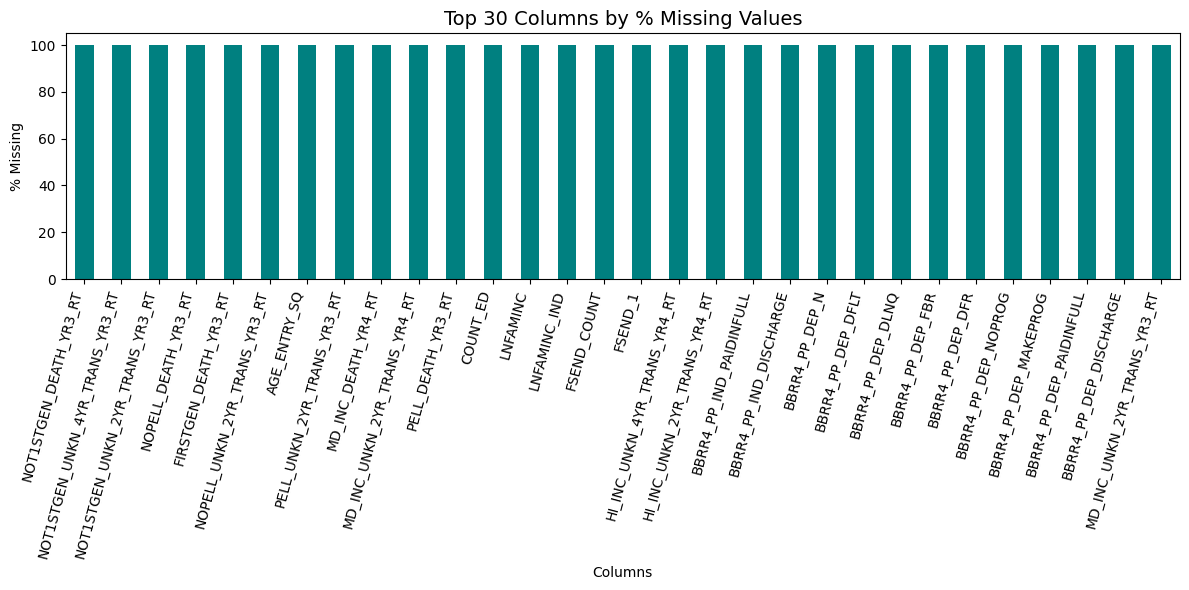

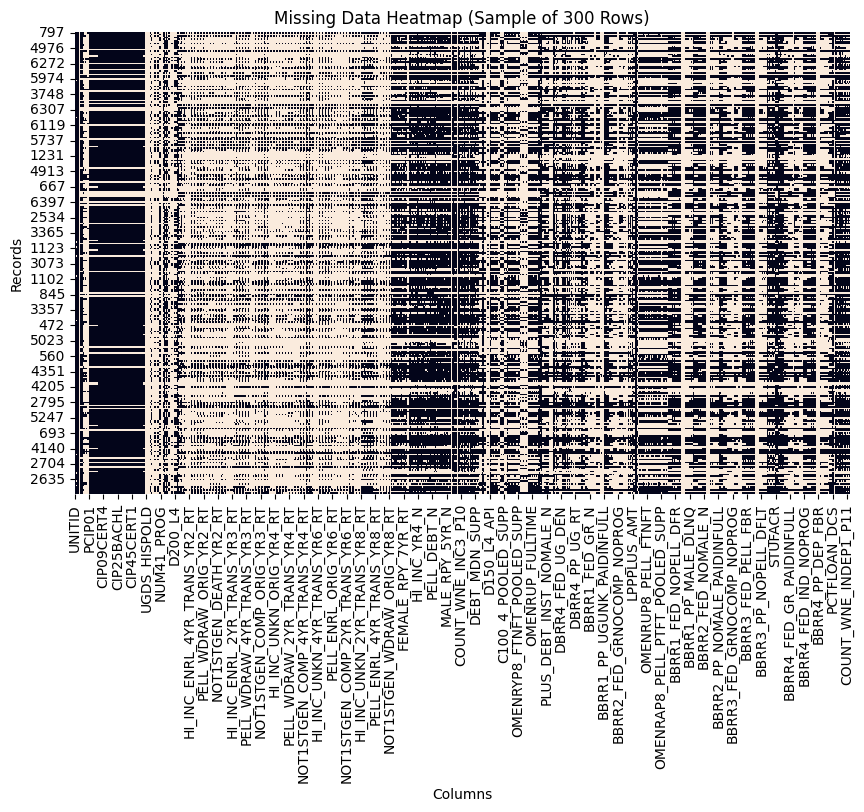

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1️⃣ Missingness by column (%)
# -------------------------------
missing_percent = df.isna().mean().round(3) * 100
missing_percent = missing_percent.sort_values(ascending=False)

print("🔍 Missingness summary (top 20 columns):\n")
print(missing_percent.head(20))

# -------------------------------
# 2️⃣ Bar chart of missingness
# -------------------------------
plt.figure(figsize=(12, 6))
missing_percent.head(30).plot(kind='bar', color='teal')
plt.title("Top 30 Columns by % Missing Values", fontsize=14)
plt.ylabel("% Missing")
plt.xlabel("Columns")
plt.xticks(rotation=75, ha='right')
plt.tight_layout()
plt.show()

# -------------------------------
# 3️⃣ Heatmap of missingness (sample)
# -------------------------------
sample = df.sample(300)  # smaller subset to keep visualization fast
plt.figure(figsize=(10, 6))
sns.heatmap(sample.isna(), cbar=False)
plt.title("Missing Data Heatmap (Sample of 300 Rows)")
plt.xlabel("Columns")
plt.ylabel("Records")
plt.show()


In [8]:
import pandas as pd 


# -------------------------------
# 🧹 Drop empty/sparse columns
# -------------------------------
before_cols = df.shape[1]
df = df.dropna(axis=1, how='all')  # drop 100% missing
df = df.loc[:, df.isna().mean() < 0.9]  # drop >90% missing
after_cols = df.shape[1]

print(f"✅ Dropped {before_cols - after_cols} columns with extreme missingness.")
print("📊 New dataset shape:", df.shape)

# Re-check missing summary
missing_percent = df.isna().mean().round(3) * 100
print("\n🔍 Remaining Missingness (Top 10 columns):")
print(missing_percent.sort_values(ascending=False).head(10))


✅ Dropped 524 columns with extreme missingness.
📊 New dataset shape: (6429, 2782)

🔍 Remaining Missingness (Top 10 columns):
IND_ENRL_ORIG_YR6_RT              89.9
DEP_ENRL_ORIG_YR6_RT              89.9
FIRSTGEN_COMP_4YR_TRANS_YR2_RT    89.9
UNKN_4YR_TRANS_YR8_RT             89.8
BBRR2_FED_GRNOCOMP_FBR            89.7
NOLOAN_UNKN_ORIG_YR2_RT           89.7
BBRR1_PP_UGNOCOMP_DLNQ            89.7
BBRR3_PP_UGUNK_MAKEPROG           89.7
BBRR1_PP_UGNOCOMP_MAKEPROG        89.6
LO_INC_ENRL_ORIG_YR6_RT           89.5
dtype: float64


In [9]:
import pandas as pd 
# -------------------------------
# 🔍 Duplicates & Numeric Sanity Checks
# -------------------------------

# 1️⃣ Check for duplicate rows
dup_count = df.duplicated().sum()
print(f"🧬 Duplicate rows found: {dup_count}")

if dup_count > 0:
    df = df.drop_duplicates()
    print(f"✅ Duplicates removed. New shape: {df.shape}")
else:
    print("✅ No duplicate rows found.")

# 2️⃣ Quick numeric summary to flag impossible values
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
summary = df[num_cols].describe().T

# Flag numeric anomalies
possible_issues = summary[(summary["min"] < 0) | (summary["max"] > 1e7)]
print("\n⚠️ Possible numeric anomalies (min < 0 or max > 10 M):")
print(possible_issues[["min", "max"]])


🧬 Duplicate rows found: 0
✅ No duplicate rows found.

⚠️ Possible numeric anomalies (min < 0 or max > 10 M):
                       min         max
UNITID            100654.0  49664501.0
LOCALE                -3.0        43.0
LATITUDE        -14.322636   71.324702
LONGITUDE      -170.742774  171.378129
CCBASIC               -2.0        33.0
CCUGPROF              -2.0        15.0
CCSIZSET              -2.0        18.0
NPT4_PUB           -3220.0     40172.0
NPT41_PUB          -6023.0     38184.0
NPT42_PUB          -4533.0     40729.0
NPT43_PUB          -2209.0     41521.0
NPT45_PUB          -3153.0     37946.0
NPT41_PRIV         -4129.0     78201.0
NPT42_PRIV         -2483.0     74499.0
NPT43_PRIV          -123.0     69323.0
NPT4_048_PUB       -4451.0     39245.0
NPT4_048_PRIV      -3006.0     76720.0
NPT4_3075_PUB      -3494.0     41055.0
NPT4_3075_PRIV      -466.0     74499.0


In [10]:
# -------------------------------
# 🎯 Target Definition
# -------------------------------

# Target variable (y)
target_col = "ADM_RATE"

if target_col in df.columns:
    y = pd.to_numeric(df[target_col], errors="coerce")
    print(f"✅ Target variable '{target_col}' successfully loaded with {y.notna().sum()} valid entries.")
else:
    raise ValueError("❌ 'ADM_RATE' not found in dataset!")

# Selected predictors (X)
selected_features = [
    'SAT_AVG', 'ACTCMMID', 'COSTT4_A', 'TUITIONFEE_IN',
    'UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN',
    'CONTROL', 'HIGHDEG', 'REGION', 'PCTPELL', 'DEBT_MDN'
]

# Convert selected features to numeric
X = df[selected_features].apply(pd.to_numeric, errors='coerce')

print(f"\n📊 Feature matrix shape: {X.shape}")
print(X.head())


✅ Target variable 'ADM_RATE' successfully loaded with 1946 valid entries.

📊 Feature matrix shape: (6429, 13)
   SAT_AVG  ACTCMMID  COSTT4_A  TUITIONFEE_IN  UGDS_WHITE  UGDS_BLACK  \
0    947.0      18.0     23751          10024      0.0180      0.9043   
1   1251.0      27.0     27826           8832      0.4832      0.2657   
2      NaN       NaN      <NA>           <NA>      0.2788      0.6681   
3   1321.0      28.0     27098          11770      0.6940      0.0907   
4    977.0      18.0     22028          11248      0.0223      0.9082   

   UGDS_HISP  UGDS_ASIAN  CONTROL  HIGHDEG  REGION  PCTPELL  DEBT_MDN  
0     0.0150      0.0017        1        4       5   0.6441   16600.0  
1     0.0776      0.0915        1        4       5   0.3318   15832.0  
2     0.0310      0.0000        2        4       5   0.6842   13385.0  
3     0.0719      0.0423        1        4       5   0.2250   13905.0  
4     0.0111      0.0018        1        4       5   0.7203   17500.0  


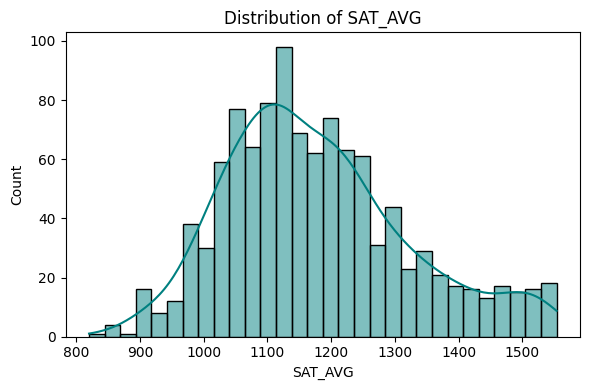

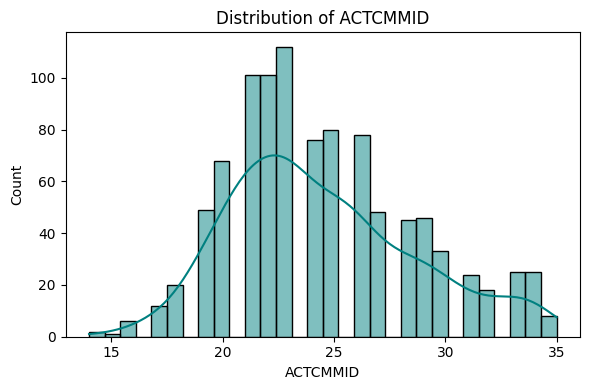

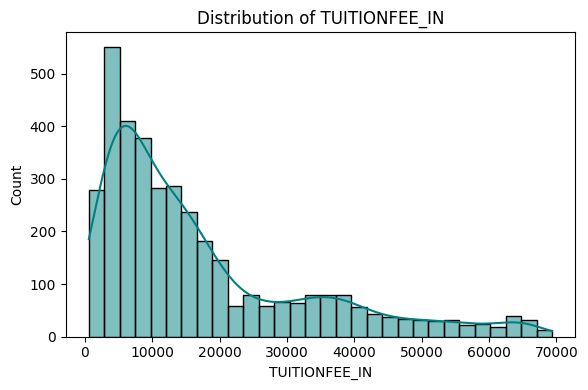

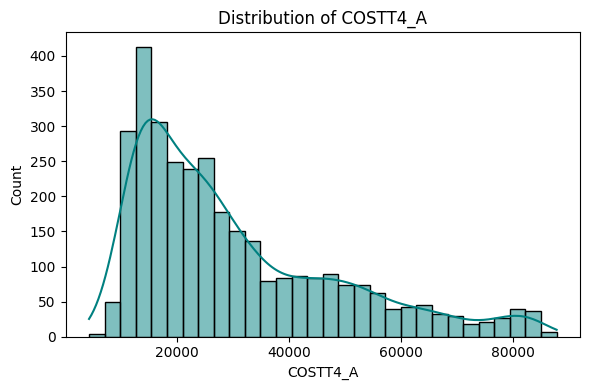

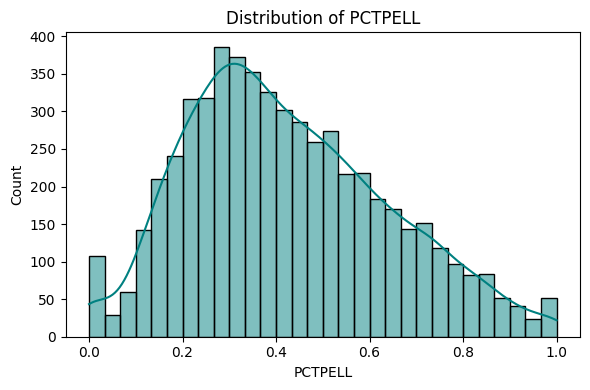

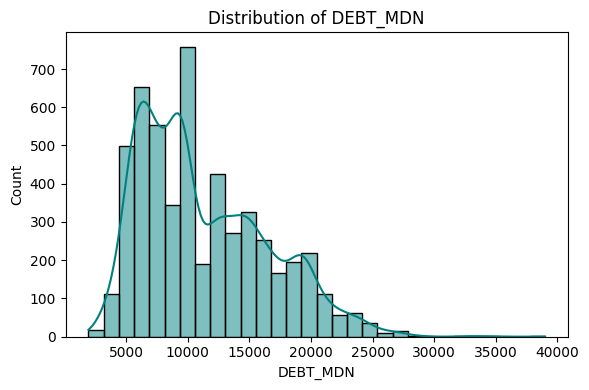

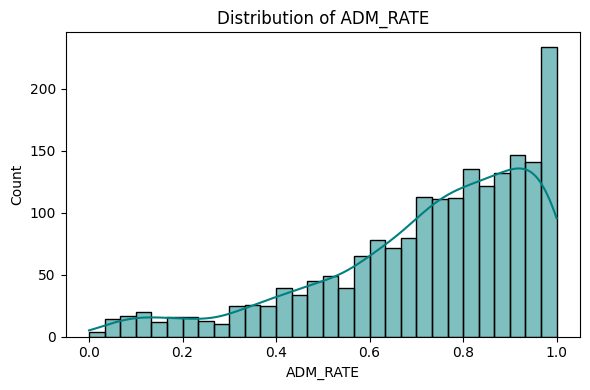

C:\Users\OWNER\AppData\Local\Temp\ipykernel_18164\2150402469.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette='crest')


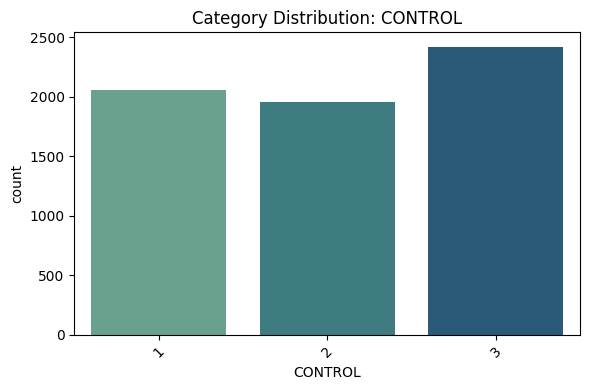

C:\Users\OWNER\AppData\Local\Temp\ipykernel_18164\2150402469.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette='crest')


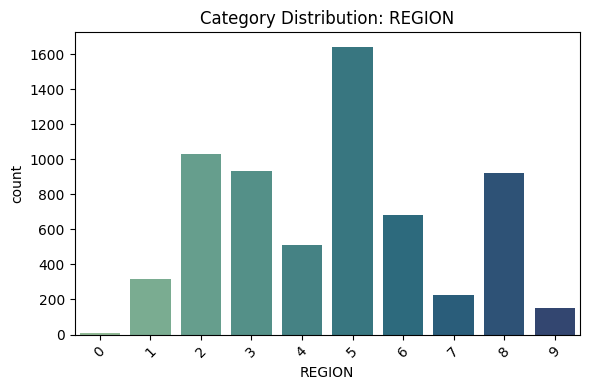

C:\Users\OWNER\AppData\Local\Temp\ipykernel_18164\2150402469.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette='crest')


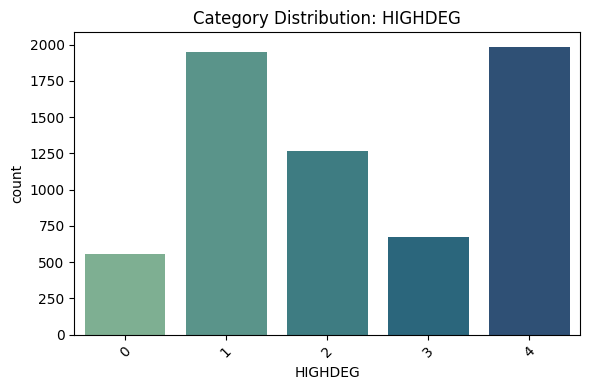

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 📈 Univariate Analysis
# -------------------------------

numeric_cols = ['SAT_AVG', 'ACTCMMID', 'TUITIONFEE_IN', 'COSTT4_A', 'PCTPELL', 'DEBT_MDN', 'ADM_RATE']
categorical_cols = ['CONTROL', 'REGION', 'HIGHDEG']

# Numeric variables — histograms
for col in numeric_cols:
    if col in df.columns:
        plt.figure(figsize=(6,4))
        sns.histplot(pd.to_numeric(df[col], errors='coerce'), bins=30, kde=True, color='teal')
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

# Categorical variables — bar charts
for col in categorical_cols:
    if col in df.columns:
        plt.figure(figsize=(6,4))
        sns.countplot(x=df[col], palette='crest')
        plt.title(f"Category Distribution: {col}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


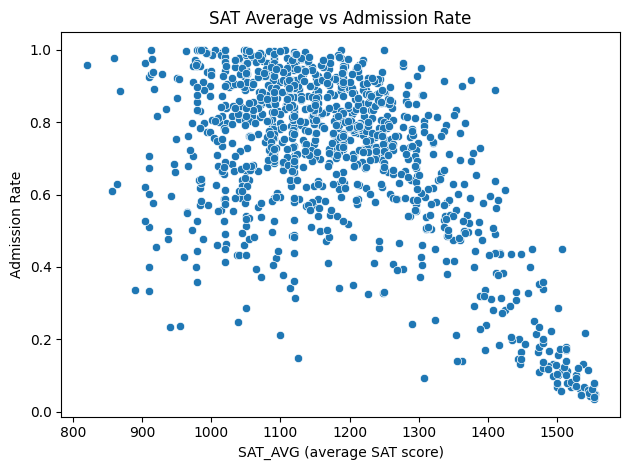

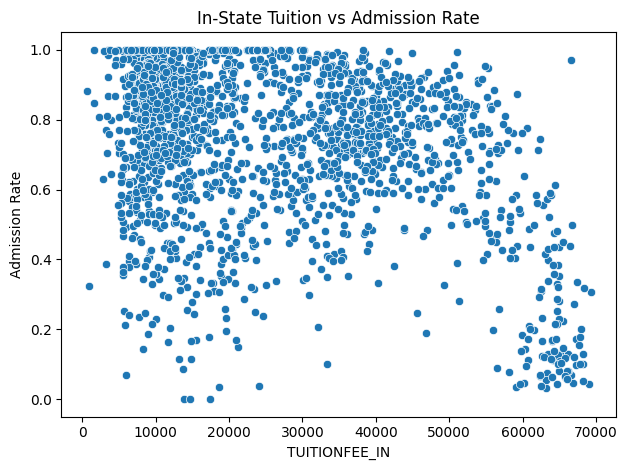

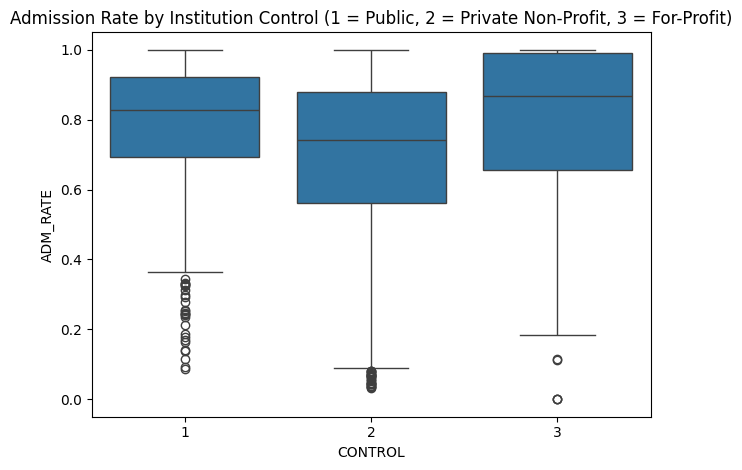

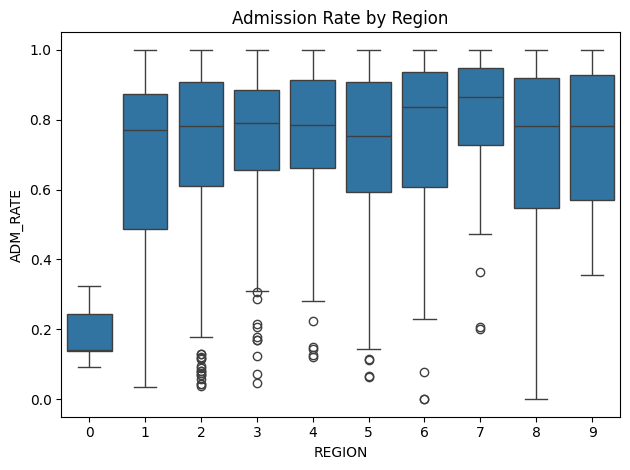

In [12]:
# -------------------------------
# 🔗 Bivariate Analysis: Admission Rate vs Key Predictors
# -------------------------------

# Numeric–numeric
sns.scatterplot(x='SAT_AVG', y='ADM_RATE', data=df)
plt.title("SAT Average vs Admission Rate")
plt.xlabel("SAT_AVG (average SAT score)")
plt.ylabel("Admission Rate")
plt.tight_layout()
plt.show()

sns.scatterplot(x='TUITIONFEE_IN', y='ADM_RATE', data=df)
plt.title("In-State Tuition vs Admission Rate")
plt.xlabel("TUITIONFEE_IN")
plt.ylabel("Admission Rate")
plt.tight_layout()
plt.show()

# Categorical–numeric
sns.boxplot(x='CONTROL', y='ADM_RATE', data=df)
plt.title("Admission Rate by Institution Control (1 = Public, 2 = Private Non-Profit, 3 = For-Profit)")
plt.tight_layout()
plt.show()

sns.boxplot(x='REGION', y='ADM_RATE', data=df)
plt.title("Admission Rate by Region")
plt.tight_layout()
plt.show()


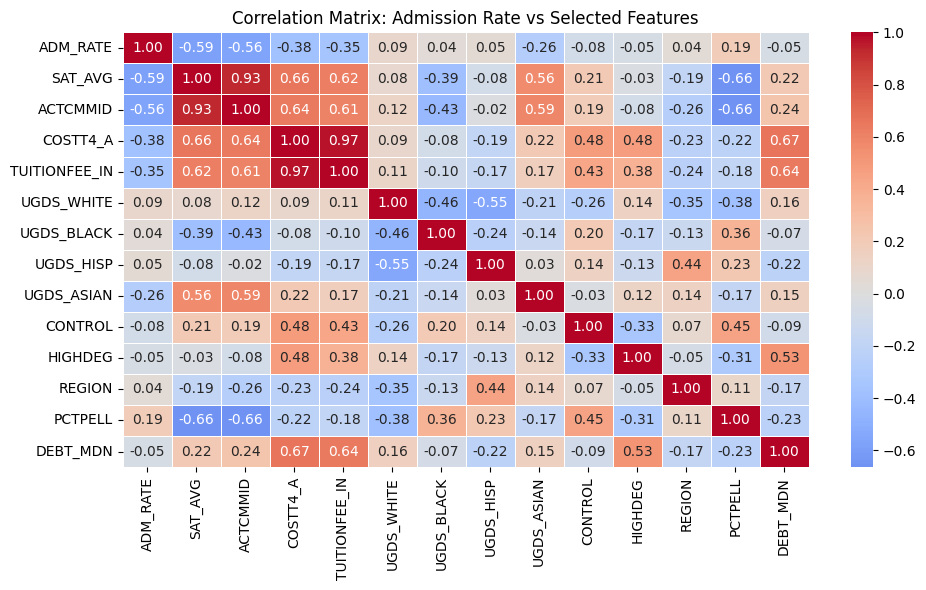

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------------
# 🧼 Clean invalid values before correlation
# -----------------------------------
invalid_values = ["PrivacySuppressed", "PS", "NULL", "NaN", "nan", ".", " "]
df = df.replace(invalid_values, np.nan)

# Only keep numeric columns for correlation
cols_for_corr = ['ADM_RATE'] + selected_features
df_corr = df[cols_for_corr].apply(pd.to_numeric, errors='coerce')

# -----------------------------------
# 🧩 Correlation Matrix
# -----------------------------------
corr = df_corr.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=True, fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix: Admission Rate vs Selected Features")
plt.tight_layout()
plt.show()
